In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk


from pathlib import Path
import torch
import numpy as np
import pandas as pd
import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Load predictions and targets from pickle file
pickle_file = "/workspace/projects/uncertainbird/notebooks/ensamble/masked_test_predictions_my_model.pkl"

with open(pickle_file, "rb") as f:
    data = pickle.load(f)

predictions = data["predictions"]
targets = data["targets"]
metadata = data["metadata"]

print(f"Loaded data with {metadata['total_samples']} samples")
print(f"Predictions shape: {predictions.shape}")
print(f"Targets shape: {targets.shape}")
print(f"Model info: {metadata['model_info']}")
print(f"Save logits: {metadata['save_logits']}")

# Display some basic statistics
print(f"\nPrediction statistics:")
print(f"  Min: {predictions.min():.4f}")
print(f"  Max: {predictions.max():.4f}")
print(f"  Mean: {predictions.mean():.4f}")
print(f"  Std: {predictions.std():.4f}")

print(f"\nTarget statistics:")
print(f"  Min: {targets.min():.4f}")
print(f"  Max: {targets.max():.4f}")
print(f"  Mean: {targets.mean():.4f}")
print(f"  Sum: {targets.sum():.0f} (total positive labels)")
# Eingaben
pred = predictions
targ = targets

# Tensors -> float32
if isinstance(pred, torch.Tensor):
    pred = pred.detach().float().cpu()
if isinstance(targ, torch.Tensor):
    targ = targ.detach().float().cpu()

# Heuristik: Sind es schon Wahrscheinlichkeiten?
# (alles in [0,1] und kein Wert <0 oder >1)
already_probs = (pred.min() >= 0.0) and (pred.max() <= 1.0)

if already_probs:
    probs = pred
else:
    probs = torch.sigmoid(pred)

# Quick-Diagnose
print("pred min/max/mean BEFORE conversion:", float(pred.min()), float(pred.max()), float(pred.mean()))
print("probs min/max/mean AFTER conversion:", float(probs.min()), float(probs.max()), float(probs.mean()))

# Falls die Logits wirklich rund um 0 liegen:
# -> das Modell ist sehr unsicher; Histogramm checken hilft
# z.B.:
# import matplotlib.pyplot as plt
# plt.hist(pred.numpy().ravel(), bins=100); plt.show()

# In DataFrame gießen (wie raw_out.csv)
probs_np = probs.numpy()
targ_np  = targ.numpy()

if probs_np.ndim == 1:  probs_np = probs_np[:, None]
if targ_np.ndim  == 1:  targ_np  = targ_np[:, None]

n_classes = probs_np.shape[1]
pred_cols   = [f"prob_class_{i}" for i in range(n_classes)]
target_cols = [f"target_class_{i}" for i in range(n_classes)]

df = pd.DataFrame(np.hstack([probs_np, targ_np]), columns=pred_cols + target_cols)
print(df.head())
print("targets shape:", targets.shape)
print("targets dtype:", targets.dtype)
print("sum over all targets:", float(targets.sum()))
print("per-class sums (first 20):",
      [int(targets[:, i].sum()) for i in range(min(targets.shape[1], 20))])
print("metadata keys:", list(metadata.keys()))

Loaded data with 12000 samples
Predictions shape: torch.Size([12000, 21])
Targets shape: torch.Size([12000, 21])
Model info: {'class_name': 'MultilabelModule', 'task': 'multilabel', 'num_classes': None}
Save logits: True

Prediction statistics:
  Min: 0.0050
  Max: 0.9702
  Mean: 0.0683
  Std: 0.0794

Target statistics:
  Min: 0.0000
  Max: 1.0000
  Mean: 0.0248
  Sum: 6254 (total positive labels)
pred min/max/mean BEFORE conversion: 0.005039215087890625 0.97021484375 0.06830450147390366
probs min/max/mean AFTER conversion: 0.005039215087890625 0.97021484375 0.06830450147390366
   prob_class_0  prob_class_1  prob_class_2  prob_class_3  prob_class_4  \
0      0.011070      0.078369      0.031311      0.042877      0.019531   
1      0.010010      0.106323      0.023331      0.016342      0.014389   
2      0.023697      0.888672      0.079468      0.113770      0.053589   
3      0.008614      0.063110      0.018829      0.015602      0.017715   
4      0.009453      0.086609      0.018

In [2]:
# Optional imports (only used if available)
try:
    from sklearn.metrics import (
        roc_auc_score, average_precision_score, roc_curve, precision_recall_curve,
        confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score,
        brier_score_loss, log_loss
    )
    SKLEARN_AVAILABLE = True
except Exception as e:
    print("scikit-learn not available; some metrics/plots will be skipped.", e)
    SKLEARN_AVAILABLE = False

In [3]:
prob_cols = [c for c in df.columns if c.startswith("prob_class_")]
target_cols = [c for c in df.columns if c.startswith("target_class_")]
print("Num samples (N):", len(df))
print("Probability columns:", prob_cols)
print("Probs min/max:", float(df[prob_cols].min().min()), float(df[prob_cols].max().max()))
C = len(prob_cols)
print("Detected classes (C):", C)


Num samples (N): 12000
Probability columns: ['prob_class_0', 'prob_class_1', 'prob_class_2', 'prob_class_3', 'prob_class_4', 'prob_class_5', 'prob_class_6', 'prob_class_7', 'prob_class_8', 'prob_class_9', 'prob_class_10', 'prob_class_11', 'prob_class_12', 'prob_class_13', 'prob_class_14', 'prob_class_15', 'prob_class_16', 'prob_class_17', 'prob_class_18', 'prob_class_19', 'prob_class_20']
Probs min/max: 0.005039215087890625 0.97021484375
Detected classes (C): 21


In [4]:
Y_true = df[target_cols].values.astype(int)  # [N, C] in {0,1}
Y_prob = df[prob_cols].values.astype(float)  # [N, C] in [0,1]
# Per-class AUROC & AUPRC
auroc_per_class = []
auprc_per_class = []
prevalence_per_class=[]
for j in range(Y_prob.shape[1]):
    try:
        auroc = roc_auc_score(Y_true[:, j], Y_prob[:, j])
        prevalence_class_i = df[f"target_class_{j}"].mean()
        
    except Exception:
        auroc = np.nan
    try:
        auprc = average_precision_score(Y_true[:, j], Y_prob[:, j])
    except Exception:
        auprc = np.nan
    auroc_per_class.append(auroc)
    auprc_per_class.append(auprc)
    prevalence_per_class.append(prevalence_class_i)
 


metrics_df = pd.DataFrame({
    "class": list(range(C)),
    "AUROC": auroc_per_class,
    "AUPRC": auprc_per_class,
    "baseline prevalence":prevalence_per_class,
})
display(metrics_df)

# Macro averages
print("Macro AUROC:", np.nanmean(auroc_per_class))
print("Macro AUPRC:", np.nanmean(auprc_per_class))

,class,AUROC,AUPRC,baseline prevalence
0,0,0.524187,0.080521,0.055917
1,1,0.651412,0.461999,0.223000
2,2,0.537217,0.114053,0.090167
3,3,0.715924,0.288356,0.001833
4,4,0.519465,0.082445,0.061250
5,5,0.541378,0.000181,0.000083
6,6,0.618404,0.103058,0.014583
7,7,0.542401,0.002852,0.002333
8,8,0.612275,0.245891,0.026667
9,9,0.614222,0.213363,0.002250


Macro AUROC: 0.676269188337208
Macro AUPRC: 0.17757885196532386


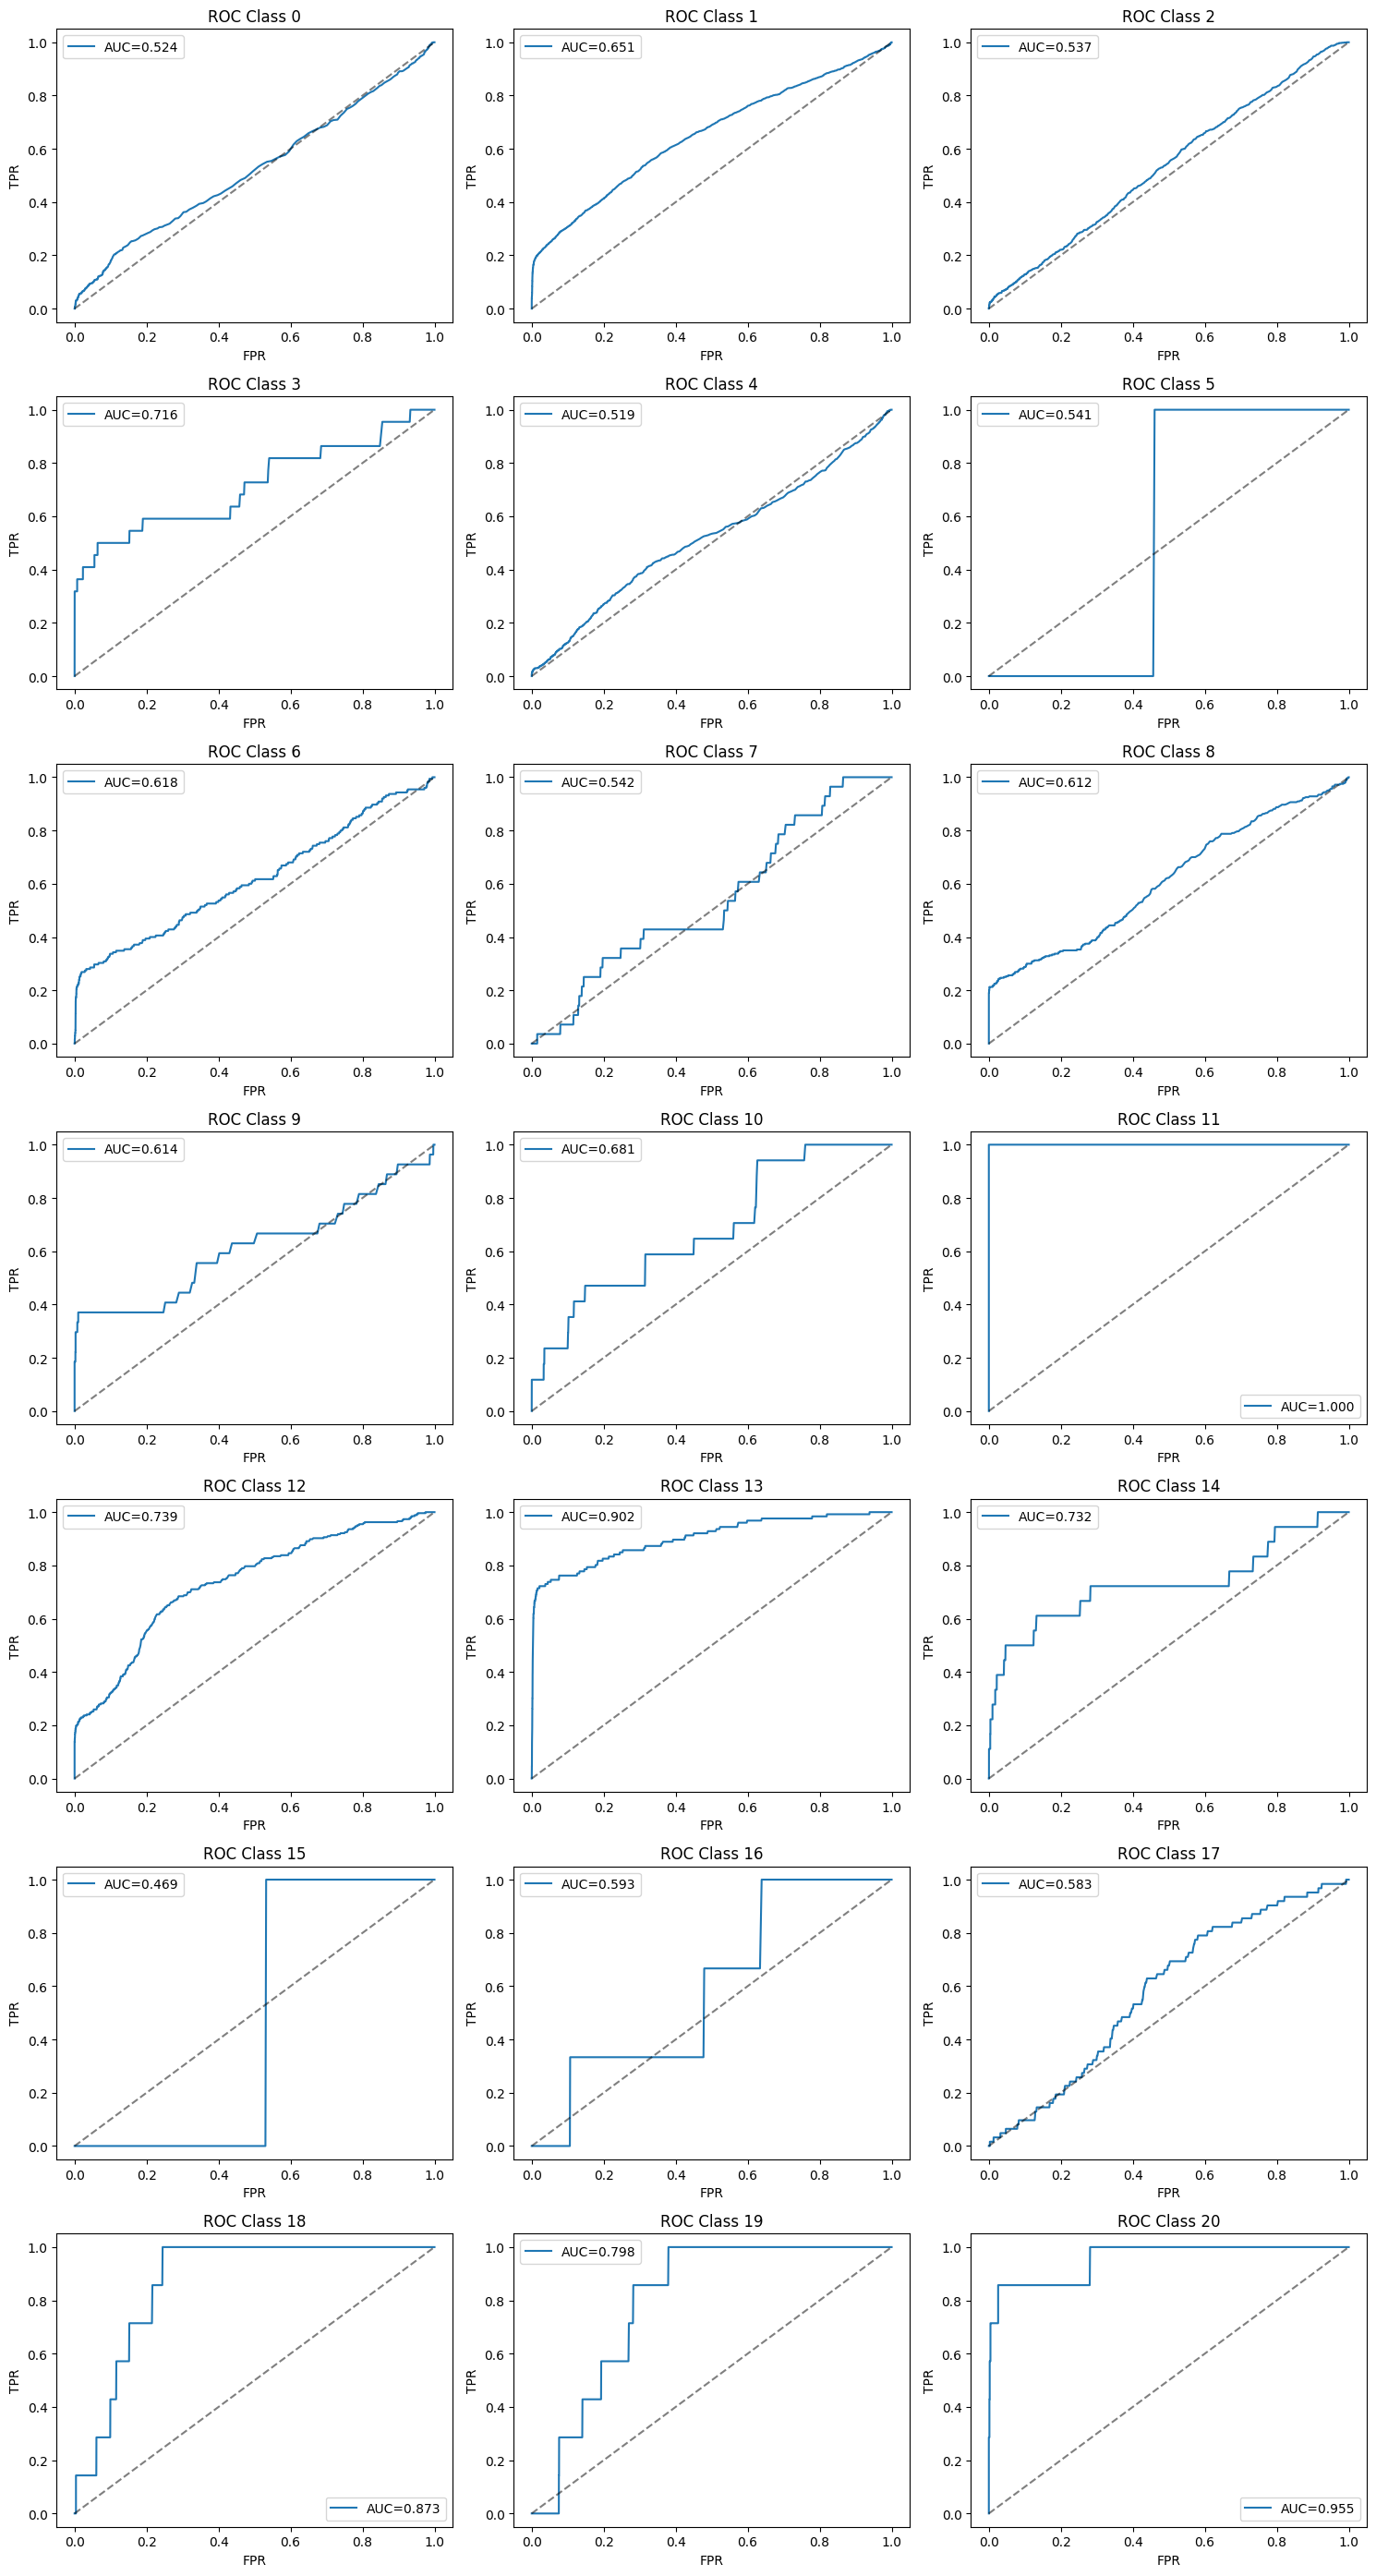

In [5]:
import math

n_classes = Y_prob.shape[1]
cols = 3                               # how many plots per row
rows = math.ceil(n_classes / cols)     # rows needed

# ---------------- ROC curves ----------------
fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
axes = axes.flatten()

for j in range(n_classes):
    ax = axes[j]
    try:
        fpr, tpr, _ = roc_curve(Y_true[:, j], Y_prob[:, j])
        ax.plot(fpr, tpr, label=f"AUC={auroc_per_class[j]:.3f}")
        ax.plot([0, 1], [0, 1], "k--", alpha=0.5)
        ax.set_title(f"ROC Class {j}")
        ax.set_xlabel("FPR")
        ax.set_ylabel("TPR")
        ax.legend()
    except Exception as e:
        ax.set_title(f"ROC Class {j} (error)")
        print(f"Skipping ROC for class {j}: {e}")

# Hide empty subplots (if n_classes not multiple of cols)
for k in range(n_classes, len(axes)):
    fig.delaxes(axes[k])

plt.tight_layout()
plt.show()


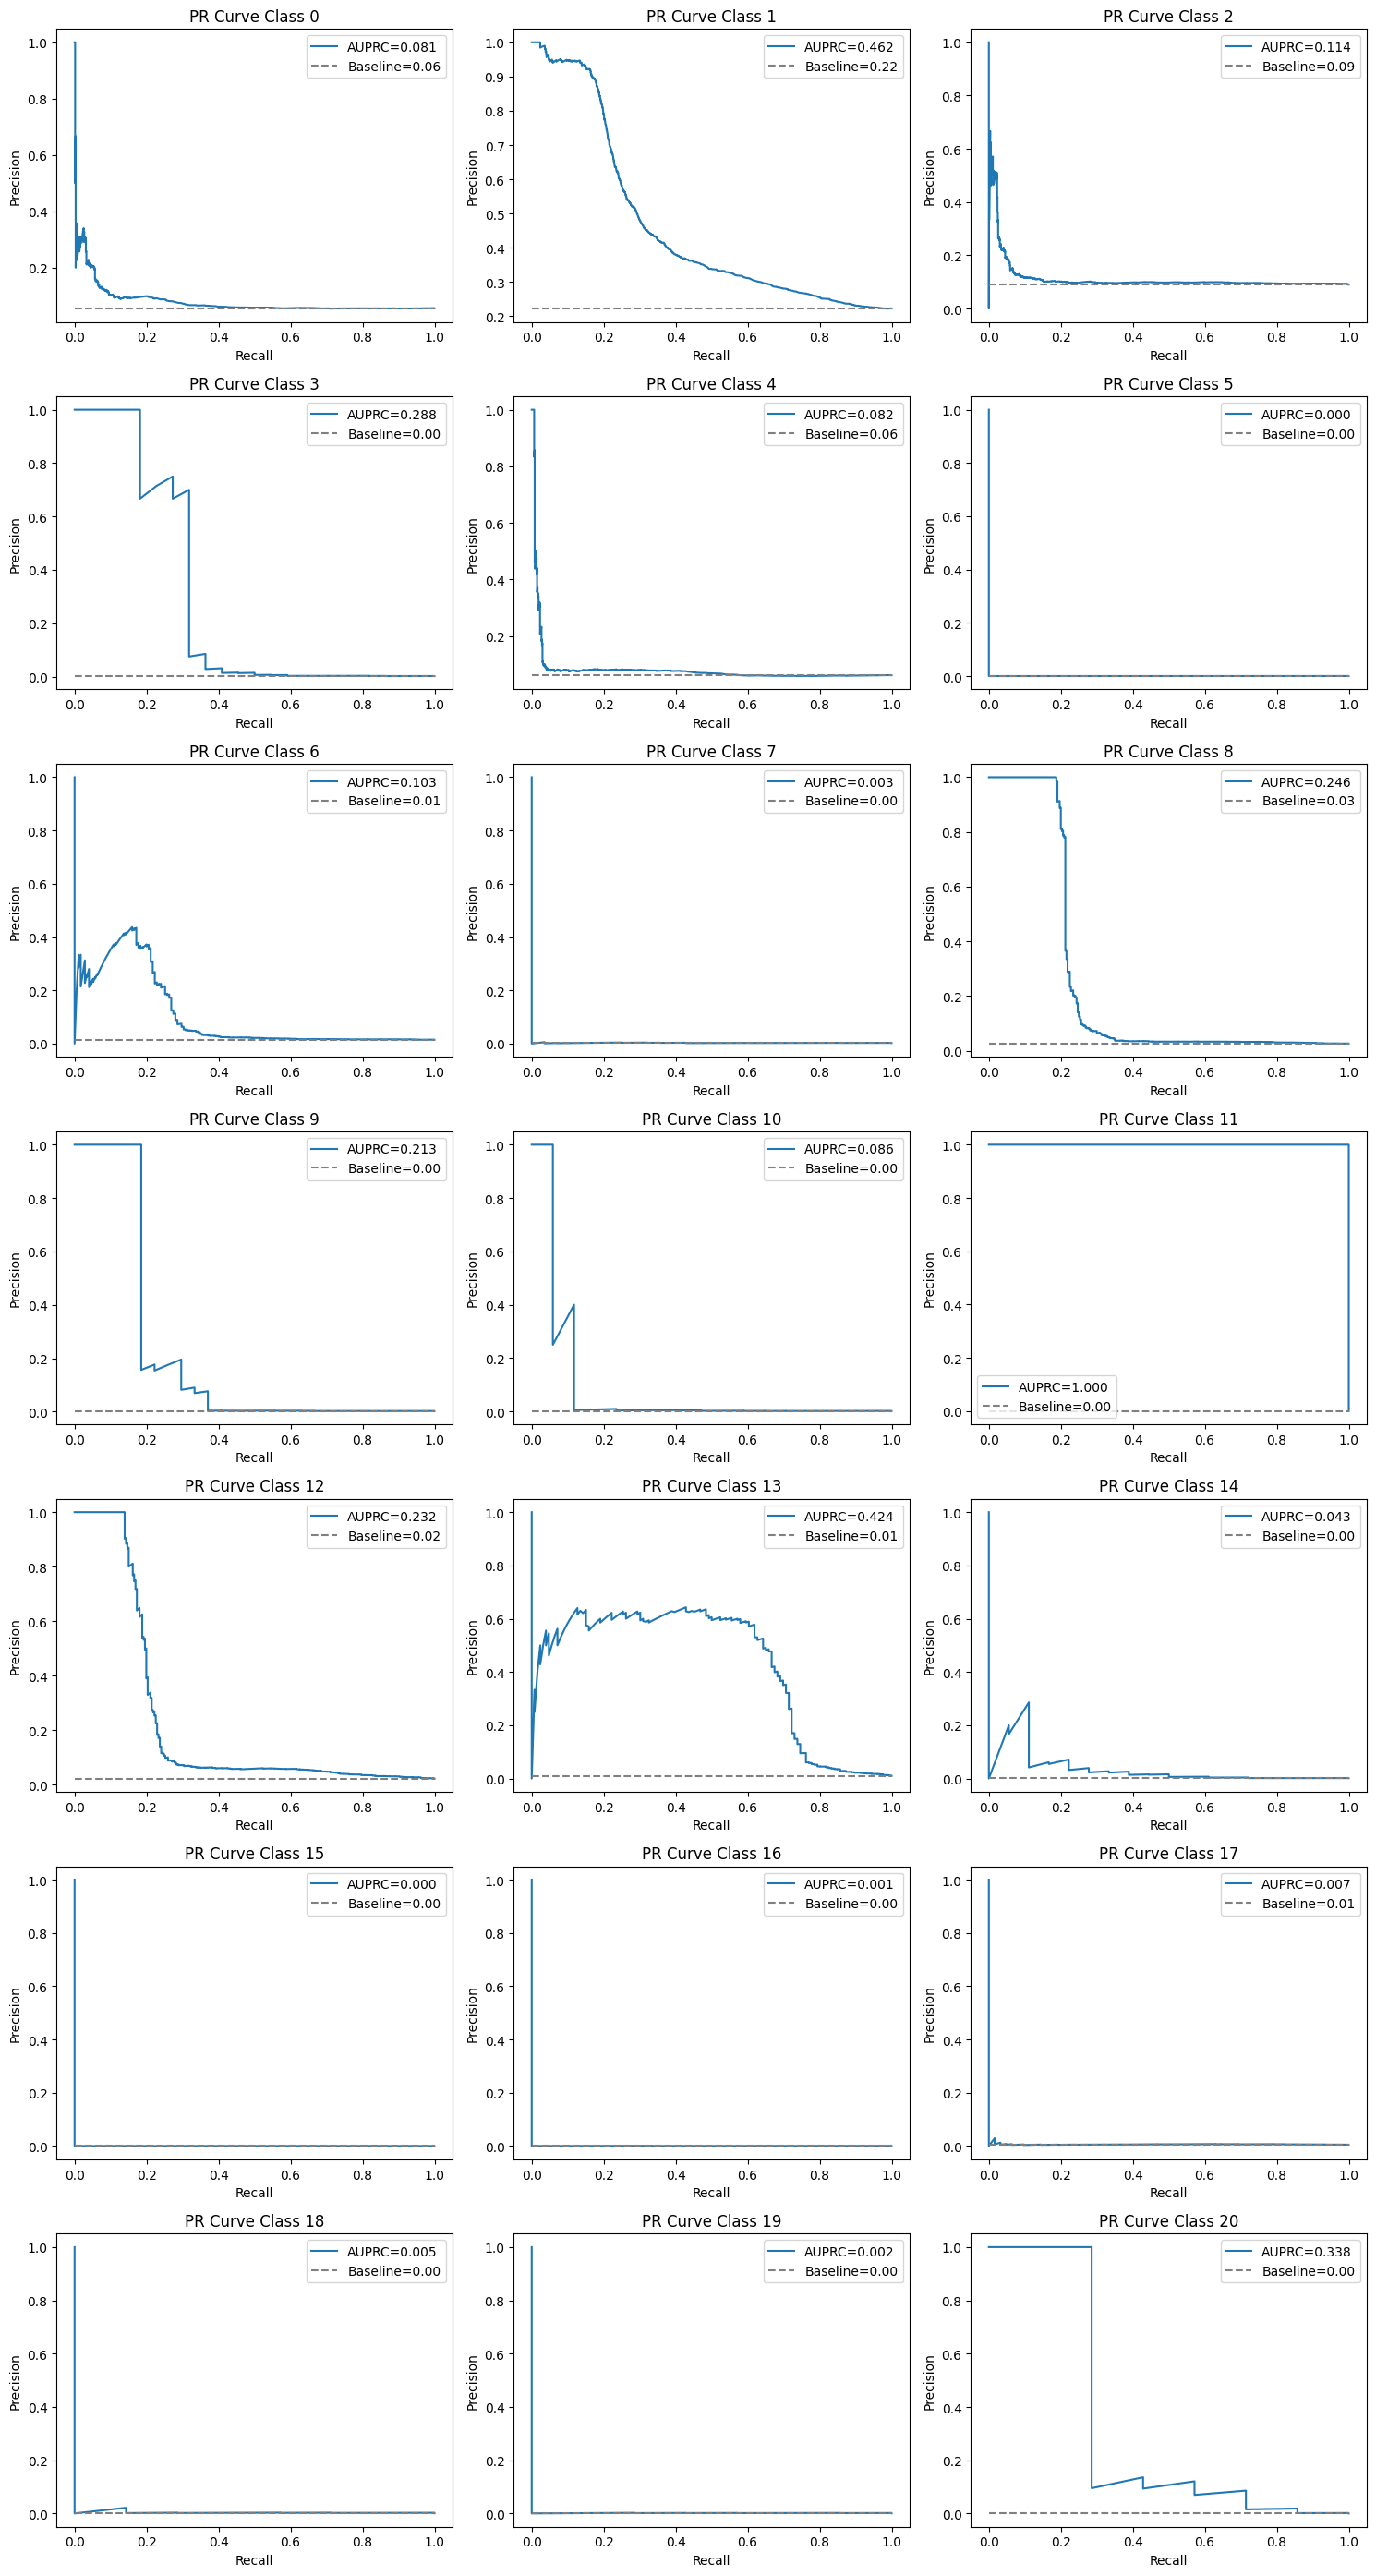

In [6]:
fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
axes = axes.flatten()

for j in range(n_classes):
    ax = axes[j]
    try:
        precision, recall, _ = precision_recall_curve(Y_true[:, j], Y_prob[:, j])
        baseline = prevalence_per_class[j]
        ax.plot(recall, precision, label=f"AUPRC={auprc_per_class[j]:.3f}")
        ax.hlines(baseline, 0, 1, colors="gray", linestyles="--", label=f"Baseline={baseline:.2f}")
        ax.set_title(f"PR Curve Class {j}")
        ax.set_xlabel("Recall")
        ax.set_ylabel("Precision")
        ax.legend()
    except Exception as e:
        ax.set_title(f"PR Class {j} (error)")
        print(f"Skipping PR for class {j}: {e}")

for k in range(n_classes, len(axes)):
    fig.delaxes(axes[k])

plt.tight_layout()
plt.show()

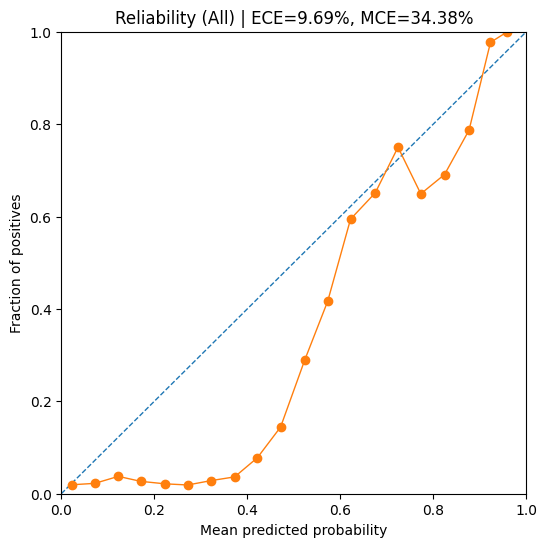

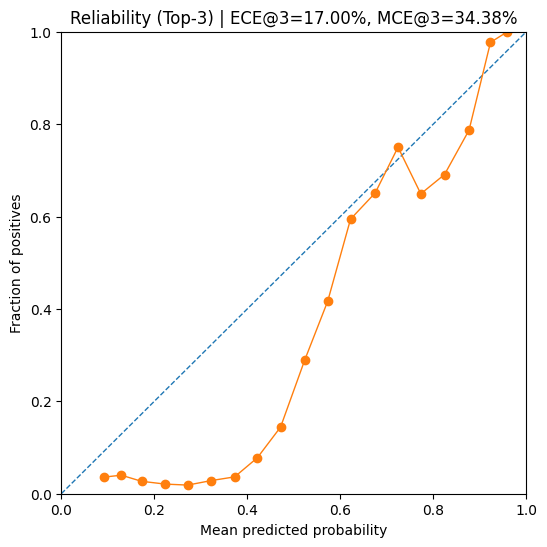

Brier: 0.02914213810339124


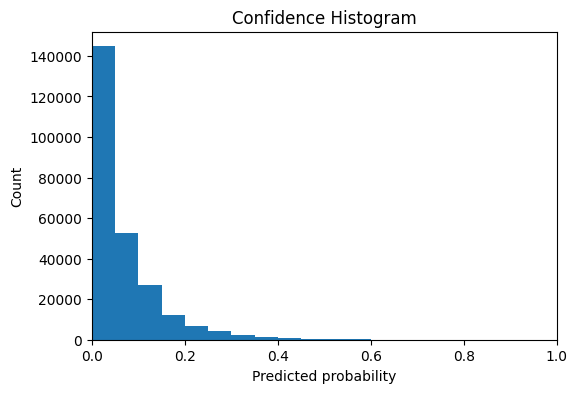

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==============================
# Extraktion aus DataFrame
# ==============================
def extract_probs_targets(df, prob_prefix="prob_class_", target_prefix="target_class_"):
    prob_cols = [c for c in df.columns if c.startswith(prob_prefix)]
    targ_cols = [c for c in df.columns if c.startswith(target_prefix)]
    if len(prob_cols) == 0 or len(targ_cols) == 0:
        raise ValueError("Keine passenden Spalten gefunden")

    def _suffix_idx(name, prefix): return int(name.replace(prefix, ""))
    prob_cols_sorted = sorted(prob_cols, key=lambda c: _suffix_idx(c, prob_prefix))
    targ_cols_sorted = sorted(targ_cols, key=lambda c: _suffix_idx(c, target_prefix))

    prob_ids = [_suffix_idx(c, prob_prefix) for c in prob_cols_sorted]
    targ_ids = [_suffix_idx(c, target_prefix) for c in targ_cols_sorted]
    if prob_ids != targ_ids:
        raise ValueError("Mismatch zwischen Prob- und Target-Spalten")

    y_prob = df[prob_cols_sorted].to_numpy(dtype=float)
    y_true = df[targ_cols_sorted].to_numpy(dtype=float)
    y_true = (y_true > 0.5).astype(int)
    y_prob = np.clip(y_prob, 0.0, 1.0)
    return y_prob, y_true

# ==============================
# Helfer für Reliability
# ==============================
def bin_stats(conf, labels, n_bins=10, quantile=False, drop_first_bin=False, min_mean_conf=None, renormalize=True):
    conf = np.asarray(conf).reshape(-1)
    labels = np.asarray(labels).reshape(-1)
    n = conf.size

    edges = (np.quantile(conf, np.linspace(0,1,n_bins+1), method="linear")
             if quantile else np.linspace(0,1,n_bins+1))
    edges[0], edges[-1] = 0.0, 1.0
    edges = np.maximum.accumulate(edges)

    bin_confs, bin_accs, bin_weights, bin_gaps = [], [], [], []
    for b in range(n_bins):
        left, right = edges[b], edges[b+1]
        m = (conf >= left) & ((conf < right) if b < n_bins-1 else (conf <= right))
        if np.any(m):
            c_mean = conf[m].mean()
            a_mean = labels[m].mean()
            w = m.sum() / n                      # Anteil an ALLEN Samples
            gap = abs(a_mean - c_mean)
        else:
            c_mean = (left + right)/2
            a_mean, w, gap = np.nan, 0.0, 0.0
        bin_confs.append(c_mean); bin_accs.append(a_mean)
        bin_weights.append(w); bin_gaps.append(gap)

    bin_confs  = np.array(bin_confs)
    bin_accs   = np.array(bin_accs)
    bin_weights= np.array(bin_weights)
    bin_gaps   = np.array(bin_gaps)

    valid = bin_weights > 0
    if drop_first_bin and np.any(valid):
        valid[0] = False
    if min_mean_conf is not None:
        valid &= (bin_confs >= float(min_mean_conf))

    if not np.any(valid):
        return bin_confs, bin_accs, bin_weights, 0.0, 0.0

    # --- entscheidend: renormalisieren ---
    if renormalize:
        w = bin_weights[valid]
        w = w / w.sum()                         # jetzt Summe = 1 über die behaltenen Bins
        ece = float(np.sum(w * bin_gaps[valid]))
    else:
        # „klassische“ ECE über alle Bins; Ausschlüsse senken den Wert mechanisch
        ece = float(np.sum(bin_weights[valid] * bin_gaps[valid]))

    mce = float(np.max(bin_gaps[valid]))
    return bin_confs, bin_accs, bin_weights, ece, mce


def brier_score(y_true, y_prob):
    return float(np.mean((y_prob - y_true) ** 2))

# ==============================
# Plot Funktionen
# ==============================
def _plot_reliability(bin_confs, bin_accs, title, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6))
    ax.plot([0,1],[0,1],"--",linewidth=1)
    mask = ~np.isnan(bin_accs)
    ax.plot(bin_confs[mask], bin_accs[mask], marker="o", linewidth=1)
    ax.set_xlim(0,1); ax.set_ylim(0,1)
    ax.set_xlabel("Mean predicted probability")
    ax.set_ylabel("Fraction of positives")
    ax.set_title(title)
    return ax

def plot_reliability_diagram_all(y_true, y_prob, n_bins=10, quantile=False, ax=None):
    conf, labels = y_prob.reshape(-1), y_true.reshape(-1)
    bin_confs, bin_accs, bin_weights, ece, mce = bin_stats(conf, labels, n_bins, quantile, drop_first_bin=True)
    title = f"Reliability (All) | ECE={ece*100:.2f}%, MCE={mce*100:.2f}%"
    _plot_reliability(bin_confs, bin_accs, title, ax=ax)
    return {"ECE": ece, "MCE": mce}

def plot_topk_reliability_diagram(y_true, y_prob, k=5, n_bins=10, quantile=False, ax=None):
    N,T = y_true.shape; k = min(k,T)
    idx = np.argpartition(-y_prob, kth=k-1, axis=1)[:, :k]
    rows = np.arange(N)[:,None]
    conf_topk = y_prob[rows, idx].reshape(-1)
    labels_topk = y_true[rows, idx].reshape(-1)
    bin_confs, bin_accs, bin_weights, ece, mce = bin_stats(conf_topk, labels_topk, n_bins, quantile, drop_first_bin=True)
    title = f"Reliability (Top-{k}) | ECE@{k}={ece*100:.2f}%, MCE@{k}={mce*100:.2f}%"
    _plot_reliability(bin_confs, bin_accs, title, ax=ax)
    return {"ECE@k": ece, "MCE@k": mce}

def plot_confidence_histogram(conf, n_bins=10, ax=None):
    conf = np.asarray(conf).reshape(-1)
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,4))
    ax.hist(conf, bins=n_bins, range=(0,1))
    ax.set_xlim(0,1)
    ax.set_xlabel("Predicted probability")
    ax.set_ylabel("Count")
    ax.set_title("Confidence Histogram")
    return ax

# ==============================
#Wrapper für DataFrame
# ==============================
def plot_reliability_from_df(df, prob_prefix="prob_class_", target_prefix="target_class_", n_bins=10, quantile=False, ax=None):
    y_prob, y_true = extract_probs_targets(df, prob_prefix, target_prefix)
    return plot_reliability_diagram_all(y_true, y_prob, n_bins=n_bins, quantile=quantile, ax=ax)

def plot_topk_reliability_from_df(df, k=5, prob_prefix="prob_class_", target_prefix="target_class_", n_bins=10, quantile=False, ax=None):
    y_prob, y_true = extract_probs_targets(df, prob_prefix, target_prefix)
    return plot_topk_reliability_diagram(y_true, y_prob, k=k, n_bins=n_bins, quantile=quantile, ax=ax)

def brier_from_df(df, prob_prefix="prob_class_", target_prefix="target_class_"):
    y_prob, y_true = extract_probs_targets(df, prob_prefix, target_prefix)
    return brier_score(y_true, y_prob)





# Klassisches Reliability Diagram
plot_reliability_from_df(df, n_bins=20, quantile=False)
plt.show()

# Top-k Reliability Diagram 
plot_topk_reliability_from_df(df, k=3, n_bins=20, quantile=False)
plt.show()

# Brier Score
print("Brier:", brier_from_df(df))

# Histogramm über alle Wahrscheinlichkeiten
probs = df[[c for c in df.columns if c.startswith("prob_class_")]].to_numpy().ravel()
plot_confidence_histogram(probs, n_bins=20)
plt.show()


In [10]:
import numpy as np
from sklearn.metrics import f1_score, average_precision_score, accuracy_score
# make sure both are numpy arrays
if isinstance(probs, torch.Tensor):
    probs_np = probs.detach().cpu().numpy()
else:
    probs_np = np.asarray(probs)

if isinstance(targ, torch.Tensor):
    targ_np = targ.detach().cpu().numpy()
else:
    targ_np = np.asarray(targ)

# cast to int for metrics
targ_bin = targ_np.astype(int)
def is_multiclass_from_targets(y, atol=1e-6):
    y = np.asarray(y)
    if y.ndim == 1:
        return True  # assume multiclass with integer labels
    row_sums = y.sum(axis=1)
    return np.allclose(row_sums, 1.0, atol=atol)

def topk_multiclass_accuracy(probs, y_true, ks=(1,5)):
    """
    probs: (N, C) probabilities
    y_true: (N,) integer class ids or one-hot (N,C)
    """
    if y_true.ndim == 2:
        y_true = y_true.argmax(axis=1)
    accs = {}
    # argsort descending
    topk_idx = np.argsort(-probs, axis=1)
    for k in ks:
        hits = (topk_idx[:, :k] == y_true[:, None]).any(axis=1)
        accs[f"top{k}_acc"] = float(hits.mean())
    # plain accuracy (top1)
    accs["acc"] = accs.get("top1_acc", None)
    return accs

def topk_multilabel_metrics(probs, y_true_bin, ks=(1,3,5)):
    """
    probs: (N, C) probabilities in [0,1]
    y_true_bin: (N, C) binary targets {0,1}
    Returns Hit@k, Precision@k, Recall@k (macro over samples).
    """
    N, C = probs.shape
    # sort preds descending
    topk_idx_all = np.argsort(-probs, axis=1)
    metrics = {}
    # avoid division by zero in per-sample recall
    true_counts = y_true_bin.sum(axis=1)  # (# true labels per sample)

    for k in ks:
        topk_idx = topk_idx_all[:, :k]
        # gather predicted positives per sample
        pred_topk = np.zeros_like(y_true_bin, dtype=bool)
        rows = np.arange(N)[:, None]
        pred_topk[rows, topk_idx] = True

        # per-sample TP@k
        tp_k = (pred_topk & (y_true_bin > 0)).sum(axis=1)

        # Hit@k: any true label in top-k?
        hit_k = (tp_k > 0).mean()

        # Precision@k: TP@k / k (macro over samples)
        prec_k = (tp_k / k).mean()

        # Recall@k: TP@k / (#true) (macro over samples with at least one true)
        mask = true_counts > 0
        if mask.any():
            rec_k = np.mean(tp_k[mask] / true_counts[mask])
        else:
            rec_k = np.nan  # undefined if no positives anywhere

        metrics[f"hit@{k}"] = float(hit_k)
        metrics[f"prec@{k}"] = float(prec_k)
        metrics[f"recall@{k}"] = float(rec_k)
    return metrics

def thresholded_multilabel_metrics(probs, y_true_bin, thr=0.5):
    """
    Classic multilabel metrics with a probability threshold.
    """
    y_pred = (probs >= thr).astype(int)
    # subset accuracy (exact match)
    subset_acc = float((y_pred == y_true_bin).all(axis=1).mean())
    # micro/macro F1
    micro_f1 = float(f1_score(y_true_bin.ravel(), y_pred.ravel(), average="micro", zero_division=0))
    macro_f1 = float(f1_score(y_true_bin, y_pred, average="macro", zero_division=0))
    return {"subset_acc": subset_acc, "micro_f1": micro_f1, "macro_f1": macro_f1}

def mean_average_precision(probs, y_true_bin):
    """
    Macro mAP across classes.
    """
    C = probs.shape[1]
    ap = []
    for c in range(C):
        y = y_true_bin[:, c]
        # AP undefined if class has no positives; skip
        if y.sum() == 0:
            continue
        ap.append(average_precision_score(y, probs[:, c]))
    return float(np.mean(ap)) if len(ap) else np.nan

# ---- Decide mode and compute ----
if is_multiclass_from_targets(targ):
    # Multiclass branch
    y_true_cls = targ.argmax(axis=1) if targ.ndim == 2 else targ.astype(int)
    mc = topk_multiclass_accuracy(probs_np, y_true_cls, ks=(1,3,5))
    print("Multiclass metrics:", mc)
else:
    # Multilabel branch
    ml_topk = topk_multilabel_metrics(probs_np, targ.astype(int), ks=(1,3,5))
    ml_thr  = thresholded_multilabel_metrics(probs_np, targ.astype(int), thr=0.5)
    mAP     = mean_average_precision(probs_np, targ.astype(int))
    print("Multilabel top-k:", ml_topk)
    print("Multilabel (thr=0.5):", ml_thr)
    print("Macro mAP:", mAP)


AttributeError: 'Tensor' object has no attribute 'astype'